In [68]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [69]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv(r"C:\Users\zacha\神州\工具\资料\data\energy_consumption\PJME_hourly.csv",
                index_col = [0],
                parse_dates = [0])
df.head()

PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0

In [70]:
from prophet import Prophet

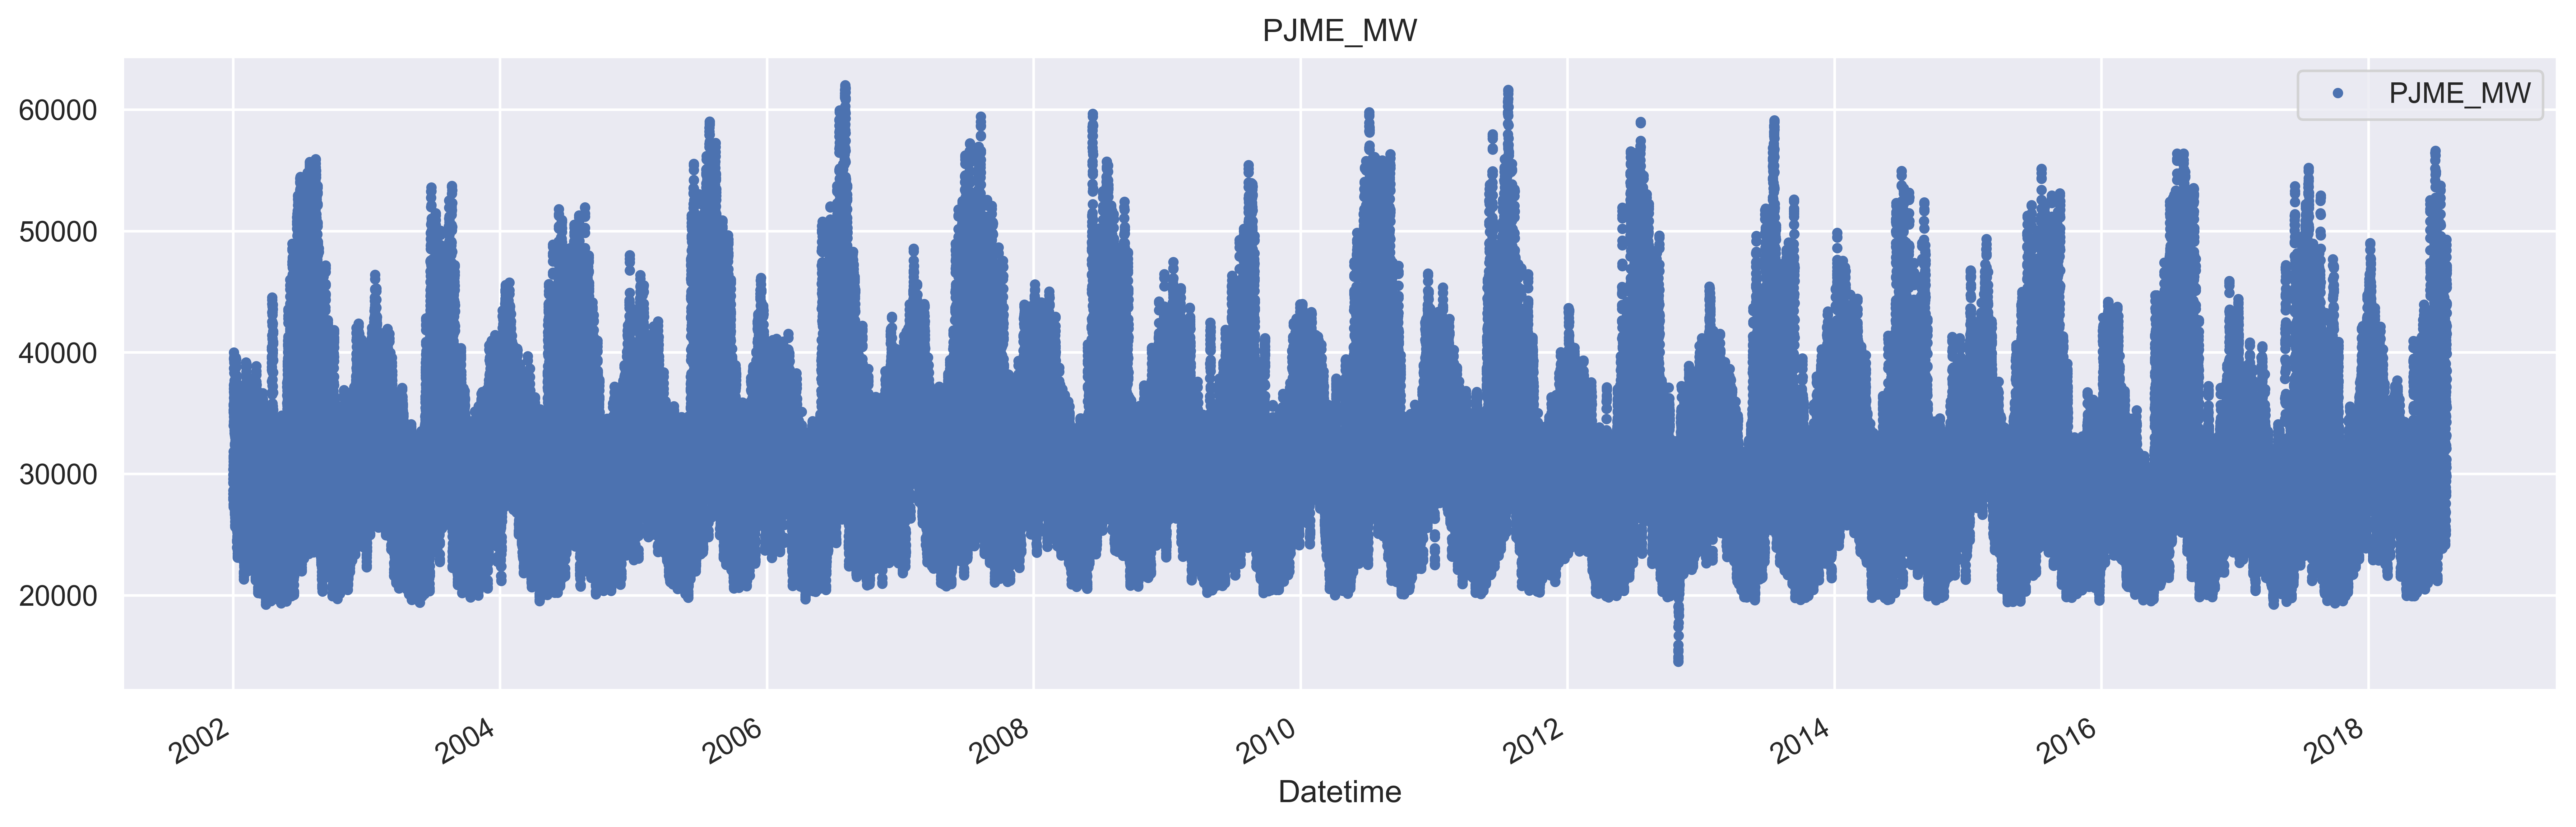

In [71]:
color_pal = sns.color_palette()

df.plot(figsize = (15,5),
        style = '.', 
        color = color_pal[0], 
        title = 'PJME_MW')

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

plt.show()

In [72]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):

    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

x, y = create_features(df, label='PJME_MW')
ft = pd.concat([x, y], axis=1)

In [73]:
ft.head()

hour  dayofweek  quarter  month  year  dayofyear  \
Datetime                                                                
2002-12-31 01:00:00     1          1        4     12  2002        365   
2002-12-31 02:00:00     2          1        4     12  2002        365   
2002-12-31 03:00:00     3          1        4     12  2002        365   
2002-12-31 04:00:00     4          1        4     12  2002        365   
2002-12-31 05:00:00     5          1        4     12  2002        365   

                     dayofmonth  weekday  season  PJME_MW  
Datetime                                                   
2002-12-31 01:00:00          31  Tuesday  Winter  26498.0  
2002-12-31 02:00:00          31  Tuesday  Winter  25147.0  
2002-12-31 03:00:00          31  Tuesday  Winter  24574.0  
2002-12-31 04:00:00          31  Tuesday  Winter  24393.0  
2002-12-31 05:00:00          31  Tuesday  Winter  24860.0

In [74]:
fig, ax = plt.subplots(figsize = (15,5))

sns.boxplot(data = ft.dropna(),
            x = 'weekday',
            y = 'PJME_MW',
            hue = 'season',
            ax = ax,
            linewidth = 1)

plt.legend(bbox_to_anchor= (1.2,1))

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


In [75]:
split_date = '01-Jan-2015'

ft_train = ft.loc[ft.index <= split_date].copy()
ft_test = ft.loc[ft.index > split_date].copy()

In [76]:
ft_train_prophet = ft_train.reset_index().rename(columns = {'Datetime': 'ds',
                                                      'PJME_MW': 'y'})

ft_test_prophet = ft_test.reset_index().rename(columns = {'Datetime': 'ds',
                                                      'PJME_MW': 'y'})

In [77]:
ft_train_prophet.head()

ds  hour  dayofweek  quarter  month  year  dayofyear  \
0 2002-12-31 01:00:00     1          1        4     12  2002        365   
1 2002-12-31 02:00:00     2          1        4     12  2002        365   
2 2002-12-31 03:00:00     3          1        4     12  2002        365   
3 2002-12-31 04:00:00     4          1        4     12  2002        365   
4 2002-12-31 05:00:00     5          1        4     12  2002        365   

   dayofmonth  weekday  season        y  
0          31  Tuesday  Winter  26498.0  
1          31  Tuesday  Winter  25147.0  
2          31  Tuesday  Winter  24574.0  
3          31  Tuesday  Winter  24393.0  
4          31  Tuesday  Winter  24860.0

In [78]:
%%time
model = Prophet()
model.fit(ft_train_prophet)

10:12:31 - cmdstanpy - INFO - Chain [1] start processing
10:13:54 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 9.83 s
Wall time: 1min 34s


In [79]:
ft_test_forecast = model.predict(ft_test_prophet)

In [80]:
ft_test_forecast.head()

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0 2015-01-01 01:00:00  31214.420813  24096.892892  33067.272392  31214.420813   
1 2015-01-01 02:00:00  31214.383693  22438.044708  31493.958744  31214.383693   
2 2015-01-01 03:00:00  31214.346573  21432.818756  30170.159728  31214.346573   
3 2015-01-01 04:00:00  31214.309453  21528.160835  30343.433375  31214.309453   
4 2015-01-01 05:00:00  31214.272334  21997.878635  31079.892121  31214.272334   

    trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0  31214.420813    -2835.417939          -2835.417939          -2835.417939   
1  31214.383693    -4339.789544          -4339.789544          -4339.789544   
2  31214.346573    -5211.485567          -5211.485567          -5211.485567   
3  31214.309453    -5353.038520          -5353.038520          -5353.038520   
4  31214.272334    -4678.701426          -4678.701426          -4678.701426   

         daily  ...       weekly  weekly_lower  weekly_upper      yearly  \
0 -4430.360197  ...  1281.390107   1281.390107   1281.390107  313.552151   
1 -5927.274407  ...  1272.632061   1272.632061   1272.632061  314.852802   
2 -6790.348748  ...  1262.668237   1262.668237   1262.668237  316.194944   
3 -6922.239359  ...  1251.622235   1251.622235   1251.622235  317.578604   
4 -6237.335097  ...  1239.629865   1239.629865   1239.629865  319.003806   

   yearly_lower  yearly_upper  multiplicative_terms  \
0    313.552151    313.552151                   0.0   
1    314.852802    314.852802                   0.0   
2    316.194944    316.194944                   0.0   
3    317.578604    317.578604                   0.0   
4    319.003806    319.003806                   0.0   

   multiplicative_terms_lower  multiplicative_terms_upper          yhat  
0                         0.0                         0.0  28379.002874  
1                         0.0                         0.0  26874.594149  
2                         0.0                         0.0  26002.861007  
3                         0.0                         0.0  25861.270933  
4                         0.0                         0.0  26535.570907  

[5 rows x 22 columns]

In [81]:
fig, ax = plt.subplots(figsize = (10,5))
fig = model.plot(ft_test_forecast, ax = ax)

ax.set_title('Prophet Forecast')

sns.set(rc={"figure.dpi":600})

plt.show()

C:\Users\zacha\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\zacha\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


In [82]:
fig = model.plot_components(ft_test_forecast)
plt.show()

C:\Users\zacha\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\zacha\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
C:\Users\zacha\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime obje

C:\Users\zacha\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\zacha\AppData\Roaming\Python\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


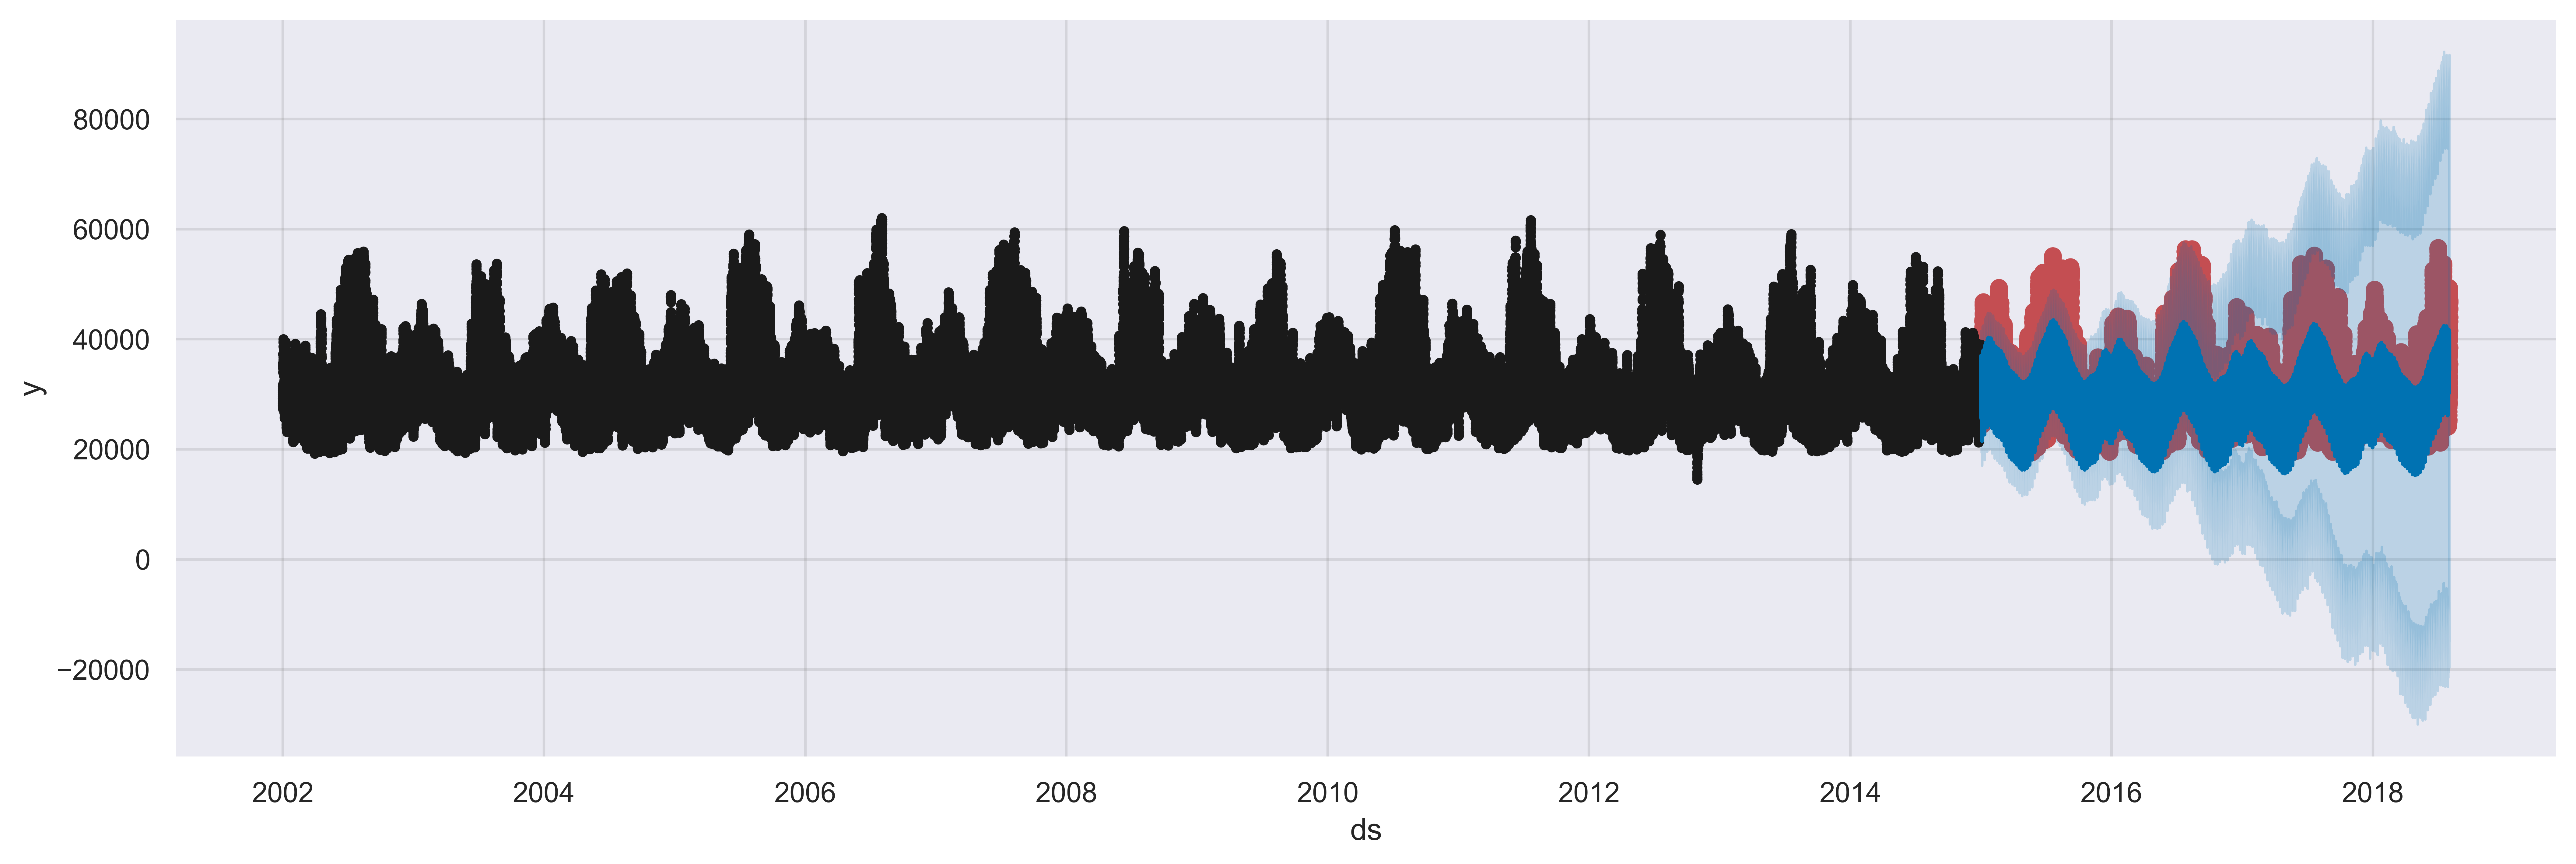

In [83]:
f, ax = plt.subplots(figsize = (15,5))
ax.scatter(ft_test.index, ft_test['PJME_MW'], color = 'r')
fig = model.plot(ft_test_forecast, ax = ax)